<a href="https://colab.research.google.com/github/juhumkwon/source_code/blob/main/faster_r_cnn_pre_trained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of Detections: 300
Bounding Box 0: (17, 81) -> (447, 565), Score: 0.056312501430511475
Bounding Box 1: (70, 113) -> (445, 389), Score: 0.037588197737932205


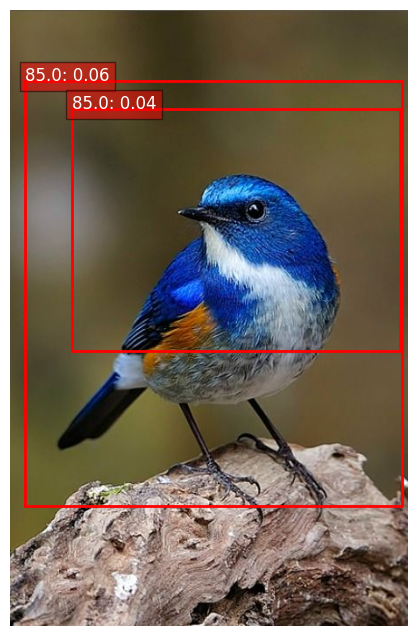

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import cv2

from google.colab import drive
drive.mount('/content/drive')

# 이미지 로드 (BGR → RGB 변환)
image_path = "/content/drive/My Drive/Data/bird.jpg"
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 모델 입력 크기에 맞게 이미지 크기 조정
input_size = 640
image_resized = cv2.resize(image, (input_size, input_size))
image_input = image_resized.astype(np.float32) / 255.0
image_input = np.expand_dims(image_input, axis=0)  # 배치 차원 추가

# TensorFlow Hub에서 Faster R-CNN 모델 로드
detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1")

# 모델 추론 실행
result = detector(image_input)
result = {key: value.numpy() for key, value in result.items()}

# 감지된 객체 개수 확인
num_detections = int(result["num_detections"][0])  # 감지된 객체 개수
print(f"Number of Detections: {num_detections}")

# 감지된 객체가 없으면 종료
if num_detections == 0:
    print("No objects detected.")
else:
    # 결과 변수 설정
    detection_boxes = result["detection_boxes"][0][:num_detections]  # 바운딩 박스 좌표
    detection_scores = result["detection_scores"][0][:num_detections]  # 신뢰도 점수
    detection_classes = result["detection_classes"][0][:num_detections]  # 클래스 이름

    # 원본 이미지 크기
    height, width, _ = image.shape
    score_threshold = 0.03  # 신뢰도 점수 기준 (낮춰서 더 많은 객체 검출)

    # 시각화 준비
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # 바운딩 박스 그리기
    for i in range(num_detections):
        score = detection_scores[i]
        if score < score_threshold:
            continue

        ymin, xmin, ymax, xmax = detection_boxes[i]

        # 정규화된 좌표를 원본 이미지 크기로 변환
        left = int(xmin * width)
        top = int(ymin * height)
        right = int(xmax * width)
        bottom = int(ymax * height)

        print(f"Bounding Box {i}: ({left}, {top}) -> ({right}, {bottom}), Score: {score}")

        # 바운딩 박스 그리기
        rect = plt.Rectangle((left, top), right - left, bottom - top, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

        # 클래스 이름 변환 (bytes → string)
        label = detection_classes[i]
        if isinstance(label, bytes):
            label = label.decode("ascii")

        # 바운딩 박스 위에 클래스 및 점수 표시
        ax.text(left, top, f"{label}: {score:.2f}", fontsize=12, color='white',
                bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()
